In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Gaussian Process Regression on a Mesh with **GPJax**

This notebooks shows how to fit a [GPJax](https://jaxgaussianprocesses.com/) Gaussian process (GP) on a mesh.

This notebook is written for GPJax 0.6.9 which requires tensorflow-probability<0.20.0, which requires tensorflow 2.11, which does not support mac-arm64. Because of this mess with dependencies, we do not test this notebook in our workflows. Hopefully, this will change in the future. **Note:** actually, GPJax 0.6.9 seems to run fine with tensorflow-probability-0.23 and tensorflow-2.15, if you are willing to force-install them breaking the formal requirements.

In [1]:
# Import a backend, we use jax in this example.
import jax.numpy as jnp
import jax
import gpjax as gpx

# Import the geometric_kernels backend.
import geometric_kernels
import geometric_kernels.jax

# Import the Mesh space and the general-purpose MaternGeometricKernel
from geometric_kernels.spaces.mesh import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

# The GPJax frontend of GeometricKernels
from geometric_kernels.frontends.gpjax import GPJaxGeometricKernel

# Sampling routines we will use to create a dummy dataset
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# Stuff
import numpy as np
import optax
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

jax.config.update("jax_enable_x64", True)

INFO (geometric_kernels): Numpy backend is enabled, as always. To enable other backends, don't forget `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): JAX backend enabled.


## Mesh Plotting Utils for `plotly`

In [2]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        intensity=vertices_colors,
        **kwargs
    )
    return plot

## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


Now we actually visualize the mesh.

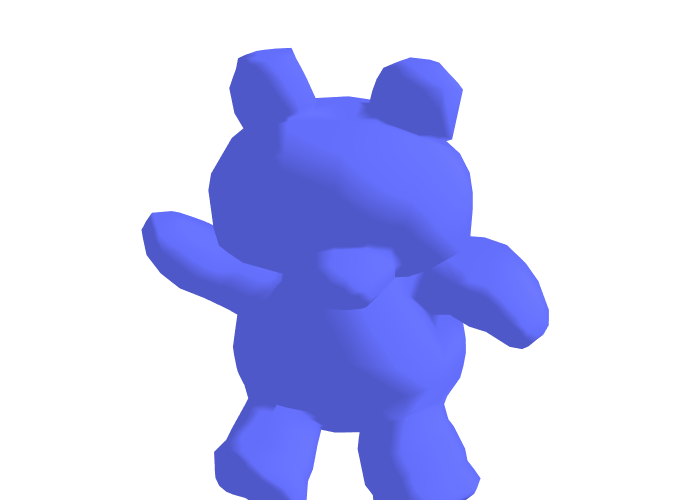

In [4]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show("png")

## Create a Dummy Dataset on the Mesh

We sample from the prior of a GP to create a simple dataset we can afterwards fit using an exact Gaussian process regression (GPR) model.

The input set $X \in \mathbb{N}^{n \times 1}$ consists of **indices** enumerating vertices of the mesh. Consequently, the elements of $X$ are in $[0, N_v-1]$, where $N_v$ are the number of vertices in the mesh.
We sample `num_data` of them into the tensor called `xs_train`. For test inputs `xs_test`, we use the whole $X$.

In [5]:
num_data = 50
key = jax.random.PRNGKey(1234)

xs_train = jax.random.randint(key, minval=0, maxval=mesh.num_vertices, shape=(num_data, 1), dtype=jnp.int64)
xs_test = jnp.arange(mesh.num_vertices, dtype=jnp.int64)[:, None]
# print("xs_train:", xs_train)
# print("xs_test:", xs_test)

To generate the corresponding outputs `ys_train` and `ys_test`, we sample from the prior. To do this, we create a `MaternGeometricKernel` object and use the efficent sampling functionality of GeometricKernels.

In [6]:
base_kernel = MaternGeometricKernel(mesh)

params = base_kernel.init_params()
params["lengthscale"] = jnp.array([5.0], dtype=jnp.float64)
params["nu"]  = jnp.array([2.5], dtype=jnp.float64)

feature_map = default_feature_map(kernel=base_kernel)
sample_paths = make_deterministic(sampler(feature_map), key)

_, ys_train  = sample_paths(xs_train, params)
key, ys_test = sample_paths(xs_test,  params)

assert(jnp.allclose((ys_test[xs_train[:, 0]]), ys_train))

# print("ys_train:", ys_train)
# print((ys_test[xs_train])[:, :, 0])

## Build a GPJax Model

Now we wrap the `base_kernel` created above into the `GPJaxGeometricKernel` to make an actual GPJax kernel.

**Note:** `params` are external to the `base_kernel` object, thus we need to pass them to the `GPJaxGeometricKernel` explicitly.
Otherwise it will use `params = base_kernel.init_params()`.

In [7]:
kernel = GPJaxGeometricKernel(base_kernel=base_kernel,
                                        nu=params["nu"],
                                        lengthscale=params["lengthscale"],
                                        variance=1.0)

# Uncomment the lines below if you want optimizable nu.
# Note: if nu is initialized to jnp.inf, it will not be optimizable either way.

# kernel = kernel.replace_trainable(nu=True)
# print("Info on Trainable Parameters:", kernel.trainables())

We use the data `xs_train`, `ys_train` and the GPJax kernel `kernel` to construct a GPJax model.

In [8]:
data = gpx.Dataset(X=xs_train, y=ys_train)

prior = gpx.Prior(mean_function=gpx.mean_functions.Zero(), kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=num_data, obs_noise=1e-4)

posterior = likelihood * prior

print("Initial model:")
print("kernel.nu =", prior.kernel.nu)
print("kernel.lengthscale =", prior.kernel.lengthscale)
print("kernel.variance =", prior.kernel.variance)
print("likelihood.obs_noise =", likelihood.obs_noise)
print("")

negative_mll = gpx.objectives.ConjugateMLL(negative=True)
print("Initial negative log marginal likelihood:", negative_mll(posterior, train_data=data))

/Users/vabor112/anaconda3/envs/gkconda_updated_sh/lib/python3.10/site-packages/gpjax/dataset.py:58: UserWarning:

X is not of type float64. Got X.dtype=int64. This may lead to numerical instability. 



Initial model:
kernel.nu = [2.5]
kernel.lengthscale = [5.]
kernel.variance = 1.0
likelihood.obs_noise = 0.0001

Initial negative log marginal likelihood: 45.696745747697115


## Train the Model (Optimize Hyperparameters)

In [9]:
negative_mll = jax.jit(negative_mll)

print("Starting training...")
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=data,
    optim=optax.sgd(0.01),
    key=key,
)
print("Final model:")
print("kernel.nu =", opt_posterior.prior.kernel.nu)
print("kernel.lengthscale =", opt_posterior.prior.kernel.lengthscale)
print("kernel.variance =", opt_posterior.prior.kernel.variance)
print("likelihood.obs_noise =", opt_posterior.likelihood.obs_noise)
print("")

print("Final negative log marginal likelihood:", negative_mll(opt_posterior, train_data=data))

Starting training...


  0%|          | 0/100 [00:00<?, ?it/s]

Final model:
kernel.nu = [2.5]
kernel.lengthscale = [4.29801996]
kernel.variance = 0.9459238
likelihood.obs_noise = 3.7371807e-05

Final negative log marginal likelihood: 43.863126607136955


## Draw Predictions and Evaluate the Model

Recall that `xs_test` contains all the locations on the mesh, i.e. all numbers from the set $\{0, 1, \ldots, N_v-1\}$.

In [10]:
# predict mean and variance
latent_dist = opt_posterior.predict(xs_test, train_data=data)
posterior_mean = jnp.reshape(latent_dist.mean(), ys_test.shape)
posterior_std = jnp.reshape(latent_dist.stddev(), ys_test.shape)

# predict sample
sample = latent_dist.sample(seed=key, sample_shape=(1,))[0, :, None]

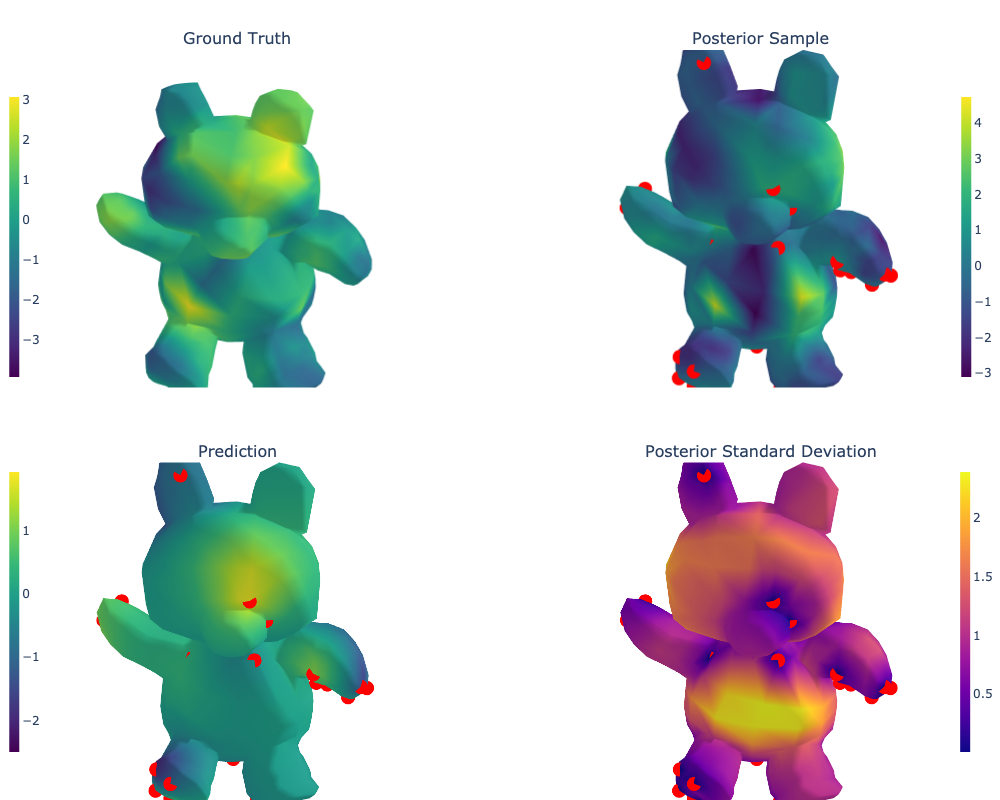

In [11]:
# Mark training data
training_data_coords = mesh.vertices[xs_train[:, 0]]

training_data_plot  = go.Scatter3d(
    x=np.array(training_data_coords[:, 0]),
    y=np.array(training_data_coords[:, 1]),
    z=np.array(training_data_coords[:, 2]),
    mode = "markers",
    marker_color = "red",
    name="",
    showlegend=False,
)

# Various plots as plotly traces
ground_truth_plot   = plot_mesh(mesh, vertices_colors=ys_test, colorscale="Viridis",
                                colorbar=dict(
                                x=0, 
                                y=0.75, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )
sample_plot         = plot_mesh(mesh, vertices_colors=sample, colorscale="Viridis",
                                colorbar=dict(
                                x=1.0, 
                                y=0.75,
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_mean_plot = plot_mesh(mesh, vertices_colors=posterior_mean, colorscale="Viridis",
                                colorbar=dict(
                                x=0.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4,
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

posterior_std_plot  = plot_mesh(mesh, vertices_colors=posterior_std, colorscale="Plasma",
                                colorbar=dict(
                                x=1.0, 
                                y=0.25, 
                                xanchor="center", 
                                yanchor="middle",
                                len=0.4, 
                                thicknessmode="fraction",
                                thickness=0.01)
                               )

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "surface"}, {"type": "surface"}],
           [{"type": "surface"}, {"type": "surface"}]],
    subplot_titles=(r"Ground Truth",
                    r"Posterior Sample",
                    r"Prediction",
                    r"Posterior Standard Deviation"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(ground_truth_plot,   row=1, col=1)

fig.add_trace(training_data_plot,  row=1, col=2)
fig.add_trace(sample_plot,         row=1, col=2)

fig.add_trace(training_data_plot,  row=2, col=1)
fig.add_trace(posterior_mean_plot,  row=2, col=1)

fig.add_trace(training_data_plot,  row=2, col=2)
fig.add_trace(posterior_std_plot, row=2, col=2)


fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={"t": 50},
)

fig.show("png", width=1000, height=800)
# fig.show()

## Citations

If you are using meshes and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@inproceedings{borovitskiy2020,
    title={Matérn Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}
}
```

```
@article{sharp2020,
    author={Nicholas Sharp and Keenan Crane},
    title={A Laplacian for Nonmanifold Triangle Meshes},
    journal={Computer Graphics Forum (SGP)},
    volume={39},
    number={5},
    year={2020}
}
```